# Predição do Estado de uma Smart Grid

A proposta deste trabalho é desenvolver e aplicar métodos de regressão para prever o estado operacional de uma rede inteligente (Smart Grid).

In [1]:
## Bibliotecas

In [2]:
# Data
from ucimlrepo import fetch_ucirepo 
import numpy as np
import pandas as pd

# Data visualization
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import clear_output
from os import cpu_count
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.colors as pc

# Errors
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Machine learning
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.svm import SVR, NuSVR
from lightgbm import LGBMRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso, LinearRegression, Ridge, ElasticNet, BayesianRidge, ARDRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, train_test_split

# Genétic
import pygad


# Domínio da Aplicação

Os dados utilizados representam simulações de uma rede elétrica inteligente (Smart Grid).

### Exploração da Base de Dados

Coletando os [dados simulados de estabilidade de uma rede elétrica](https://archive.ics.uci.edu/dataset/471/electrical+grid+stability+simulated+data)

In [3]:
electrical_grid_stability_simulated_data = fetch_ucirepo(id=471).data

features = electrical_grid_stability_simulated_data.features 
targets = electrical_grid_stability_simulated_data.targets

data = pd.merge(features, targets, left_index=True, right_index=True, how='outer')

### Explicando os Atributos

- tau[x]: Tempo de reação do participante (valor real no intervalo [0.5, 10] segundos). 
    - tau1 - o valor para o produtor de eletricidade;
- p[x]: Potência nominal consumida (negativa) ou produzida (positiva) (valor real). 
    - Para consumidores, no intervalo [-0.5, -2] segundos^-2;
    - p1 = abs(p2 + p3 + p4);
- g[x]: Coeficiente (gamma) proporcional à elasticidade de preço (valor real no intervalo [0.05, 1] segundos^-1). 
    - g1 - o valor para o produtor de eletricidade;
- stab: A parte real máxima da raiz da equação característica (se positiva - o sistema é linearmente instável) (valor real).
- stabf: A classificação de estabilidade do sistema (categórica: estável/instável).


### Visualização os Dados

In [4]:
data.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tau1    10000 non-null  float64
 1   tau2    10000 non-null  float64
 2   tau3    10000 non-null  float64
 3   tau4    10000 non-null  float64
 4   p1      10000 non-null  float64
 5   p2      10000 non-null  float64
 6   p3      10000 non-null  float64
 7   p4      10000 non-null  float64
 8   g1      10000 non-null  float64
 9   g2      10000 non-null  float64
 10  g3      10000 non-null  float64
 11  g4      10000 non-null  float64
 12  stab    10000 non-null  float64
 13  stabf   10000 non-null  object 
dtypes: float64(13), object(1)
memory usage: 1.1+ MB


In [6]:
# data.describe()

# Pré-Processamento dos Dados

### Eliminação do dado discreto, `stabf`

Com o objetivo de prever o próximo estado da rede, a partir do valor contínuo `stab`, temos que eliminar o valor `stabf` já que depende de `stab`.

In [7]:
data.drop(columns=['stabf'], inplace=True)

### Análise das Correlações

Analisar as correlações das váriaveis para escolher as melhores váriaveis para os modelos de regressão.

<Axes: >

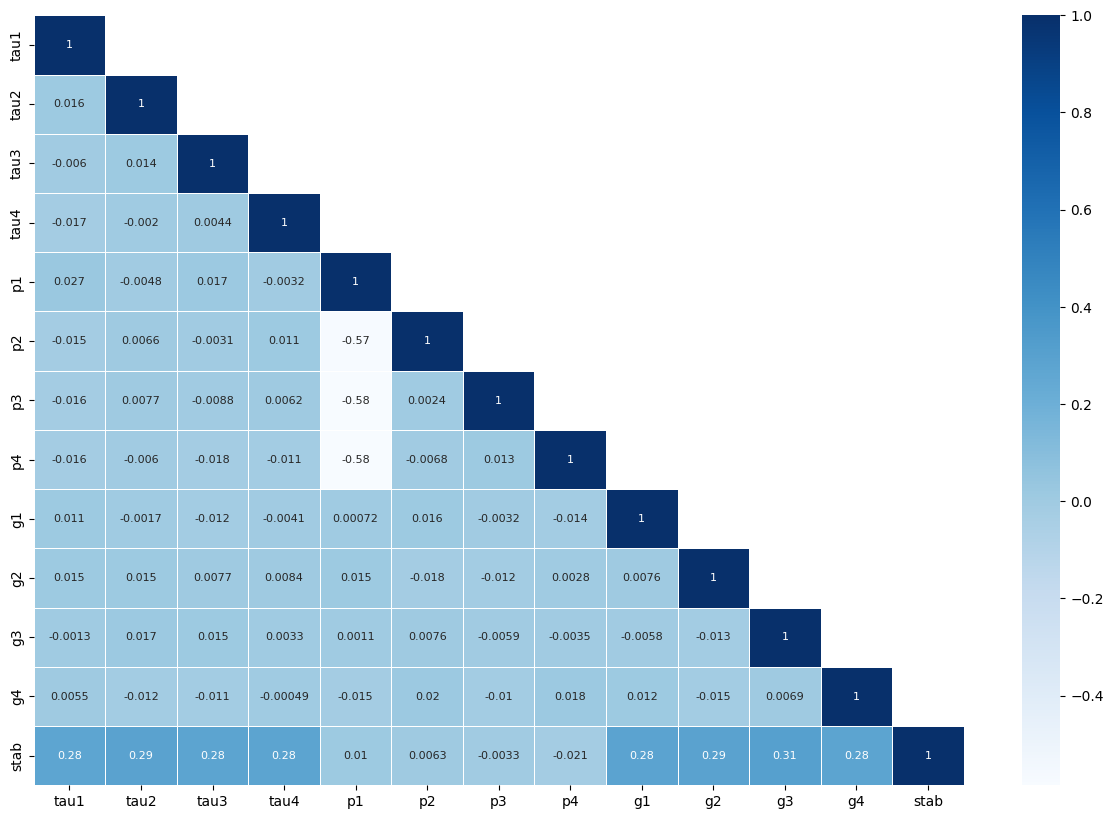

In [8]:
correlation_matrix = data.corr()

# Mantém apenas o triângulo superior
correlation_matrix = np.tril(correlation_matrix)

# Substitui os zeros por NaN para que não apareçam no mapa de calor
correlation_matrix[correlation_matrix == 0] = np.nan

height = 10
width = 15
plt.figure(figsize=(width, height))
sns.heatmap(correlation_matrix,
            annot=True,
            xticklabels=data.columns,  
            yticklabels=data.columns,
            annot_kws={"size": 8},
            linewidth=.5,
            cmap="Blues")



## Limpeza os dados

Vendo a baixa correlação das variáveis $p_x$ com $stab$, é decidido a remoção desses valores, para melhorar o aprendizado do modelo.

In [9]:
data.drop(columns=['p1', 'p2', 'p3', 'p4'], inplace=True)

# Reconhecimento de Padrões e Aprendizados

### Definição de Métodos e Classes de Apoio

In [10]:
def create_data_structure():
    '''
    Cria um objeto com a estrutura de dados preparada para armazenar as informações durante os treinamentos.
    '''
    return {
        "r2": [],
        "mse": [],
        "mae": [],
        "pred": [],
        "test": [],
        "mape": [],
    }

def get_class_name(object):
    return object.__class__.__name__

class Fitter:
    '''
    Classe de apoio para facilitar no treinamento de cada modelo.
    '''
    def __init__(self, x_train, y_train, x_test, y_test) -> None:
        self.__x_train = x_train
        self.__y_train = y_train
        self.__x_test = x_test
        self.__y_test = y_test

    def fit_model_and_measure(self, model, data):
        model.fit(self.__x_train, self.__y_train)
        
        pred = model.predict(self.__x_test)

        data['pred'].append(pred)
        data['test'].append(self.__y_test)
        data['r2'].append(r2_score(self.__y_test, pred))
        data['mse'].append(mean_squared_error(self.__y_test, pred))
        data['mae'].append(mean_absolute_error(self.__y_test, pred))
        data['mape'].append(np.mean(np.abs((self.__y_test - pred) / self.__y_test)) * 100)

### Definição dos modelos a serem usados.

Exploração de vários modelos definidos pela literatura, para entender qual melhor resolve o problema.

In [11]:
MODELS = [
    BayesianRidge(),
    ARDRegression(),
    Lasso(alpha=0.1),
    Ridge(alpha=1.0),
    LinearRegression(),
    SVR(kernel='linear', C=1.0),
    NuSVR(nu=0.5, kernel='rbf'),
    LGBMRegressor(max_depth=10, verbose=-1),
    KNeighborsRegressor(n_neighbors=5),
    ElasticNet(alpha=0.1, l1_ratio=0.5),
    AdaBoostRegressor(n_estimators=100),
    SGDRegressor(max_iter=1000, tol=1e-3),
    ExtraTreesRegressor(n_estimators=100),
    XGBRegressor(learning_rate=0.1, max_depth=8), 
    MLPRegressor(hidden_layer_sizes=(100,), max_iter=500),
    RandomForestRegressor(n_estimators=100, random_state=0),
    HistGradientBoostingRegressor(max_iter=100, learning_rate=0.1),
    GradientBoostingRegressor(n_estimators=100, learning_rate=0.1),
    DecisionTreeRegressor(max_depth=5, splitter='random', min_samples_leaf=5),
]

### Treinamento e Validação dos Primeiros Modelos

Treinamento dos 18 modelos escolhidos para verificar os melhores candidatos.

In [12]:
outputs = {}

for model in MODELS:
    outputs[get_class_name(model)] = create_data_structure()
 
five_folds = KFold(n_splits=5, random_state=0, shuffle=True)

STAB_COLUMN_INDEX = list(data.columns).index('stab')

number_of_operations = len(MODELS) * 5 

progress_bar = tqdm(total=number_of_operations)

y_data = data['stab'].values
x_data = data.drop(columns=['stab']).values

for index, (train_index, test_index) in enumerate(five_folds.split(data)):
    y_train = y_data[train_index]
    x_train = x_data[train_index]

    y_test = y_data[test_index]
    x_test = x_data[test_index]

    fitter = Fitter(
        x_train=x_train,
        x_test=x_test,
        y_train=y_train,
        y_test=y_test,
    )

    for model in MODELS:
        fitter.fit_model_and_measure(model, data=outputs[get_class_name(model)])
        progress_bar.update()

 99%|█████████▉| 94/95 [01:35<00:01,  1.49s/it]

### Definindo funções de apoio para visualização

In [13]:
def create_metrics(error_structure):
    metrics = {
        'MSE': error_structure['mse'], 
        'MAE': error_structure['mae'], 
        'MAPE': error_structure['mape'],
        'R2': error_structure['r2']
    }

    mean_std = {metric: (np.mean(scores), np.std(scores)) for metric, scores in metrics.items()}

    return mean_std

### Geração de Visibilidades dos Primeiros modelos

In [14]:
METRICS = ['MSE', 'MAE', 'MAPE', 'R2']


model_metrics = {}

for model in MODELS:
    model_metrics[get_class_name(model)] = create_metrics(outputs[get_class_name(model)])

# Função para plotar gráficos de métricas
def plot_metrics(metric_name, model_metrics:dict, reverse=False):
    width = 0.2
    sorted_metrics = sorted(model_metrics.items(), key=lambda x:x[1][metric_name][0], reverse=reverse)

    
    fig = make_subplots(rows=len(sorted_metrics), cols=1, subplot_titles=[model_name for model_name, _ in sorted_metrics])
    
    # Lista de modelos e métricas
    model_names = [model_name for model_name, _ in sorted_metrics]
    heights = [metric_values[metric_name][0] for _, metric_values in sorted_metrics]
    y_errors = [metric_values[metric_name][1] for _, metric_values in sorted_metrics]
    
    # Criação do gráfico de barras com erros
    fig = go.Figure()
    colors = pc.sample_colorscale('Viridis', len(model_names))
    fig.add_trace(
        go.Bar(
            x=model_names,  # Nome dos modelos no eixo X
            y=heights,  # Valores das métricas no eixo Y
            error_y=dict(type='data', array=y_errors),
            marker_color=colors[:len(model_names)],# Adiciona o erro como barras de erro
            name=metric_name  # Nome da métrica para referência
        )
    )
    
    # Atualização do layout para melhor visualização
    fig.update_layout(
        title="Comparação de Modelos",
        xaxis_title="Modelos",
        yaxis_title=metric_name,
        barmode='group',  # As barras são agrupadas lado a lado
        height=600,
        width=1000
    )
    
    fig.show()



### Filtragem dos Modelos

A partir dessa primeira comparação, será escolhido três melhores modelos, considerando as visibilidades
- NuSVR
- LGBMRegressor
- HistGradientBoostingRegressor

E para cada modelo, aplicar o método de GridSearch para encontrar os melhores parâmetros para cada modelo.

In [15]:
BEST_MODELS = [
    (NuSVR(), {
        'nu': [0.1,0.3, 0.5,0.8, 0.9],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    }),
    (HistGradientBoostingRegressor(), {
        'learning_rate': [0.01, 0.1, 0.3],
        'max_iter': [100, 200, 300],        
        'max_depth': [None, 10, 20],
        'l2_regularization': [0.0, 0.1, 0.5]
    }), 
    (LGBMRegressor(), {
        'boosting_type': ['gbdt', 'dart', 'rf'],
        'max_depth': [5, 10, 20],
        'learning_rate': [0.01, 0.1, 0.3],
        'verbosity': [-1]
    })
]

### Treinamento e busca dos melhores modelos

In [16]:
number_of_cpus = cpu_count()

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

y_data = data['stab'].values
x_data = data.drop(columns=['stab']).values

fitter = Fitter(
    x_train=x_train,
    x_test=x_test,
    y_train=y_train,
    y_test=y_test,
)

best_outputs = {}

for model, _ in BEST_MODELS:
    best_outputs[get_class_name(model)] = create_data_structure()

for model, params in BEST_MODELS:
    model_name = get_class_name(model)

    grid_search = HalvingGridSearchCV(model, params, n_jobs=number_of_cpus, cv=2, scoring='r2') #['r2', 'neg_median_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error']

    fitter.fit_model_and_measure(grid_search, data=best_outputs[get_class_name(model)])

    best_outputs[model_name]['best_params'] = grid_search.best_params_
    best_outputs[model_name]['best_model'] = grid_search.best_estimator_

clear_output()

### Visualização dos Resultados dos Três Modelos

In [17]:
METRICS = ['MSE', 'MAE', 'MAPE', 'R2']

model_metrics = {}

for model,_ in BEST_MODELS:
    model_name = get_class_name(model)

    try:
        plot_tree(best_outputs[model_name]['best_model']._predictors[0][0])
        print(best_outputs[model_name]['best_params'])
    except:
        pass
    model_metrics[model_name] = create_metrics(best_outputs[model_name])

for metric in METRICS:
    plot_metrics(metric, model_metrics, metric == 'R2')



distinct_colors = pc.qualitative.Set1  # Paleta com cores bem distintas
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=list(range(0, len(y_test), 30)),  # Índices (subsample a cada 30)
        y=y_test[::30],  # Valores reais
        mode='markers',
        name='True Value',
        marker=dict(color='black', symbol='circle'),  # Cores e símbolo
    )
)
for i, (model, params) in enumerate(BEST_MODELS):
    model_name = get_class_name(model)
    fig.add_trace(
        go.Scatter(
            x=list(range(0, len(y_test), 30)),  # Índices (subsample a cada 30)
            y=best_outputs[model_name]['pred'][0][::30],  # Previsões do modelo
            mode='lines',
            name=model_name,
            line=dict(color=distinct_colors[i % len(distinct_colors)], dash='dash'),  # Cores e estilo de linha
        )
    )

fig.update_layout(
    title="Comparação de Previsões de Modelos",
    xaxis_title="Índice",
    yaxis_title="Valor",
    height=600,
    width=1000,
    legend_title="Legenda",
)

fig.show()



## Discussão

Ao avaliar o desempenho dos modelos Nu Support Vector Regression (NuSVR), LightGBMRegressor (LGBM) e Histogram-Based Gradient Boosting Regression (HistGradientBoostingRegressor), observa-se que o NuSVR está superando os outros dois em termos de performance. No entanto, este modelo só atinge tais resultados quando utiliza cerca de 90% dos dados como Vetores de Suporte, o que sugere um possível sobreajuste (overfitting). Para mitigar este problema, é recomendável reduzir a proporção de dados utilizados como Vetores de Suporte, visando melhorar a capacidade de generalização do modelo.

Por outro lado, tanto o HistGradientBoostingRegressor quanto o NuSVR demonstram tendência ao sobreajuste em suas atuais configurações. Em contraste, o LightGBMRegressor se destaca por apresentar uma maior resistência ao overfitting, mantendo um desempenho mais estável e generalizável. Este comportamento sugere que o LightGBMRegressor pode ser uma escolha mais robusta em cenários onde a generalização é crítica, enquanto os outros modelos requerem ajustes mais finos para evitar sobreajuste.








In [18]:
## Genética

In [19]:
data_gen = pd.merge(features, targets, left_index=True, right_index=True, how='outer')

In [20]:
data_gen.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable


In [21]:
objective = data_gen['stab']
data_gen = data_gen.drop(columns=['stab', 'stabf'], axis=1)

In [22]:
data_gen.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923


In [23]:
objective

0       0.055347
1      -0.005957
2       0.003471
3       0.028871
4       0.049860
          ...   
9995    0.023892
9996   -0.025803
9997   -0.031810
9998    0.037789
9999    0.045263
Name: stab, Length: 10000, dtype: float64

In [24]:
function_inputs = [] # Function inputs.
eq = []
for i in range(1000):
    for j in data_gen:
        eq.append(data_gen[j][i])
    function_inputs.append(eq)
    eq = []
    
ob = []
desired_outputs = []
for i in range(1000):
    ob.append(objective[i])
    desired_outputs.append(ob)
    ob = []


In [25]:
import numpy as np
import pygad

# Construção dos inputs das funções
function_inputs = []  # Function inputs.
for i in range(1000):
    eq = []
    for j in data_gen:
        eq.append(data_gen[j][i])
    function_inputs.append(eq)

# Construção dos outputs desejados
desired_outputs = []  # Desired outputs.
for i in range(1000):
    ob = []
    ob.append(objective[i])
    desired_outputs.append(ob)

def fitness_func(ga_instance, solution, solution_idx):
    total_error = 0
    # Para cada equação, calcula o erro total
    for i in range(len(function_inputs)):
        output = np.sum(solution * function_inputs[i])
        error = np.abs(output - desired_outputs[i][0])
        total_error += error
    # Fitness é a inversa do erro total, para minimizar o erro
    fitness = 1.0 / (total_error + 0.000001)
    return fitness

num_generations = 10000  # Number of generations.
num_parents_mating = 10  # Number of solutions to be selected as parents in the mating pool.

sol_per_pop = 20  # Number of solutions in the population.
num_genes = len(function_inputs[0])

last_fitness = 0

def on_generation(ga_instance):
    global last_fitness
    best_fitness = ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]
    print(f"Generation = {ga_instance.generations_completed}")
    print(f"Fitness    = {best_fitness}")
    print(f"Change     = {best_fitness - last_fitness}")
    last_fitness = best_fitness

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       fitness_func=fitness_func,
                       on_generation=on_generation)

# Executando o algoritmo genético para otimizar os parâmetros da função.
ga_instance.run()

# Retornando os detalhes da melhor solução.
solution, solution_fitness, solution_idx = ga_instance.best_solution(ga_instance.last_generation_fitness)
print(f"\n\n\nParameters of the best solution : {solution}")
print(f"Fitness value of the best solution = {solution_fitness}")
print(f"Index of the best solution : {solution_idx}")

# Calculando a previsão para cada equação com a melhor solução encontrada.
predictions = [np.sum(np.array(function_inputs[i]) * solution) for i in range(len(function_inputs))]
for i, prediction in enumerate(predictions):
    print(f"Predicted output for equation {i+1} : {prediction}, Expected: {desired_outputs[i][0]}")

if ga_instance.best_solution_generation != -1:
    print(f"Best fitness value reached after {ga_instance.best_solution_generation} generations.")

# Salvando a instância do GA.
filename = 'genetic'  # Nome do arquivo onde a instância será salva. O nome é sem extensão.
ga_instance.save(filename=filename)


/home/vjchave/Downloads/smartgrid-ai-project-main/smartgrid-ai-project-main/.venv/lib/python3.12/site-packages/pygad/pygad.py:1139: UserWarning:

The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.



Generation = 1
Fitness    = 0.00010704995641754434
Change     = 0.00010704995641754434
Generation = 2
Fitness    = 0.00017742173481461452
Change     = 7.037177839707018e-05
Generation = 3
Fitness    = 0.00018855017004220525
Change     = 1.1128435227590735e-05
Generation = 4
Fitness    = 0.00019694454362831001
Change     = 8.394373586104761e-06
Generation = 5
Fitness    = 0.00019775311931508893
Change     = 8.085756867789106e-07
Generation = 6
Fitness    = 0.0002294281094163356
Change     = 3.1674990101246685e-05
Generation = 7
Fitness    = 0.0002294281094163356
Change     = 0.0
Generation = 8
Fitness    = 0.0002294281094163356
Change     = 0.0
Generation = 9
Fitness    = 0.00023505975712927142
Change     = 5.631647712935804e-06
Generation = 10
Fitness    = 0.0002363642417646915
Change     = 1.3044846354200786e-06
Generation = 11
Fitness    = 0.00027973719531648717
Change     = 4.3372953551795674e-05
Generation = 12
Fitness    = 0.0002826864230193651
Change     = 2.9492277028779577e-06


/home/vjchave/Downloads/smartgrid-ai-project-main/smartgrid-ai-project-main/.venv/lib/python3.12/site-packages/pygad/visualize/plot.py:109: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



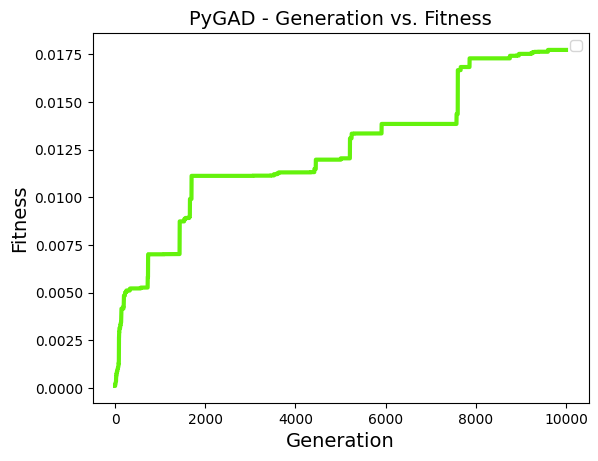

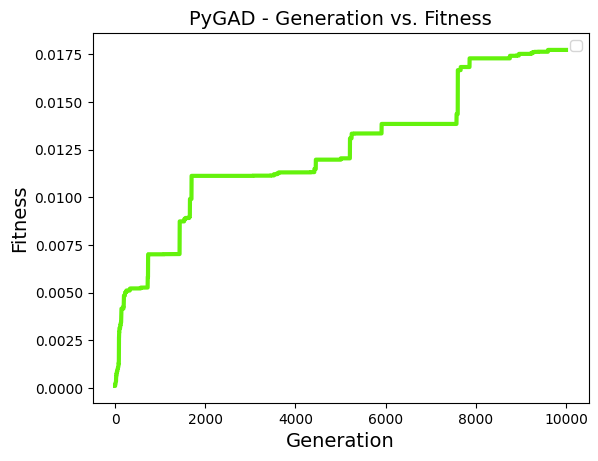

In [26]:
# Loading the saved GA instance.
loaded_ga_instance = pygad.load(filename=filename)
loaded_ga_instance.plot_fitness()

## Conclusão

Conclui-se que, embora o modelo NuSVR apresente desempenho superior em determinadas condições, sua eficácia está fortemente atrelada a uma configuração que pode levar ao sobreajuste, comprometendo sua capacidade de generalização. Da mesma forma, o HistGradientBoostingRegressor também exibe sinais de overfitting, necessitando de ajustes adicionais para melhorar sua robustez. Em contrapartida, o LightGBMRegressor demonstrou maior resistência ao overfitting, destacando-se como uma opção mais confiável para modelos de regressão que exigem estabilidade e precisão em ambientes de dados variados. Portanto, a escolha do modelo ideal deve considerar não apenas o desempenho imediato, mas também a capacidade de generalização, com o LightGBMRegressor emergindo como uma alternativa sólida em contextos onde a generalização é uma prioridade.

### Referências Bibliográficas

- Deng, Y., Cao, K. K., Hu, W., et al. (2023). "Harmonized and Open Energy Dataset for Modeling a Highly Renewable Brazilian Power System." *Scientific Data*, 10, 103. https://doi.org/10.1038/s41597-023-01992-9

- Brown, T., Hörsch, J., & Schlachtberger, D. (2018). "PyPSA: Python for Power System Analysis." *Journal of Open Research Software*, 6(1). arXiv:1707.09913. DOI:10.5334/jors.188

- SAP Insights. "The Smart Grid: How AI is Powering Today’s Energy Technologies." Disponível em: SAP Insights. Acesso em: 11 jul. 2024.

- Satu, Md & Khan, Md Imran. (2024). "Machine Learning Approaches To Predict The Stability of Smart Grid." https://doi.org/10.21203/rs.3.rs-3866218/v1

- Deng, Y. (2021). "PyPSA-Brazil: A Free and Open Model of the Brazilian Electrical System." *Energy Proceedings*.

- Zheng, X., Xu, N., Trinh, L., et al. (2022). "A multi-scale time-series dataset with benchmark for machine learning in decarbonized energy grids." *Scientific Data*, 9, 359. https://doi.org/10.1038/s41597-022-01455-7
